# AirBnB Data Analysis: Modelling & Inference

In the current repository, I will analyze the [AirBnB dataset from the Basque Country / Euskadi](http://insideairbnb.com/get-the-data/). The [Basque Country](https://en.wikipedia.org/wiki/Basque_Country_(autonomous_community)) is the region from Spain I am from; after many years living in Germany, I moved back here in 2020. As a popular touristic target on the seaside, the analysis might be valuable for many visitors :-)

The first notebook `00_AirBnB_DataAnalysis_Initial_Tests.ipynb` has defined the main business questions, related to:

1. Most important features for price prediction (= target)
2. Difference in features between the two most important cities: Donostia-San Sebastian & Bilbao
3. Difference in features between cities with beach access and without
4. EXTRA: Predict review score from review texts

Now, the usual data science process continues:

1. Data cleaning and Preparation
2. Exploratory Data Analysis
3. Feature Engineering
4. Feature Selection
5. **Modelling**
6. **Model Scoring & Inferences**
7. Answering and presenting the Business Questions

The previous notebook `02_AirBnB_DataAnalysis_DataCleaning_EDA.ipynb` has performed the Feature Engineering and Selection.

This notebook focuses on the next two steps: **Modelling** and **Model Scoring & Inference**. The processed train/test splits are loaded here, together with additional files (e.g., scaler, mappings, selected features, etc.).

### Overview of Contents in the Current Notebook

1. Load Dataset & Additional Files

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# To save the model
import joblib

# Display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

## 1. Load Dataset & Additional Files

In [13]:
filepath = './data/euskadi_2022_03_31/'

y_train = pd.read_csv(filepath+'listings_y_train.csv')
X_train = pd.read_csv(filepath+'listings_X_train.csv')

y_test = pd.read_csv(filepath+'listings_y_test.csv')
X_test = pd.read_csv(filepath+'listings_X_test.csv')

In [14]:
scaler = joblib.load(filepath+'minmax_scaler.joblib', mmap_mode='r')

In [15]:
property_types = joblib.load(filepath+'property_types.joblib', mmap_mode='r')

In [25]:
selected_features = joblib.load(filepath+'selected_features.joblib', mmap_mode='r')

In [26]:
numerical_transform_params = joblib.load(filepath+'numerical_transform_params.joblib', mmap_mode='r')

## 2. Model: Linear Regression

### 2.1 Training and Evaluation

#### Select Features

In [65]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

#### Fit Model

In [108]:
#lm = Lasso(alpha=0.001, random_state=0)
lm = Ridge(alpha=0.001, random_state=0)
#lm = LinearRegression()

# Lasso: Train
lm.fit(X_train, y_train)

Ridge(alpha=0.001, random_state=0)

#### Inference

In [109]:
# Lasso: Predictions
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

#### Evaluate

In [110]:
# Train: RMSE, R2
print('Train RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred_train), squared=False))))
print('Train R2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred_train))))

print('Test RMSE: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred_test), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred_test))))
print()

print('Average listing price: ', int(np.exp(y_train).median()))

Train RMSE: 240
Train R2: 0.5417346530485132
Test RMSE: 225
test r2: 0.5411595676179022

Average listing price:  194


#### Scatterplot: True vs. Predicted

In [111]:
np.exp(y_train).quantile(0.85)

price    484.307767
Name: 0.85, dtype: float64

(-142.83619002763672,
 2999.559990580371,
 -173.32121945335768,
 3639.745608520511)

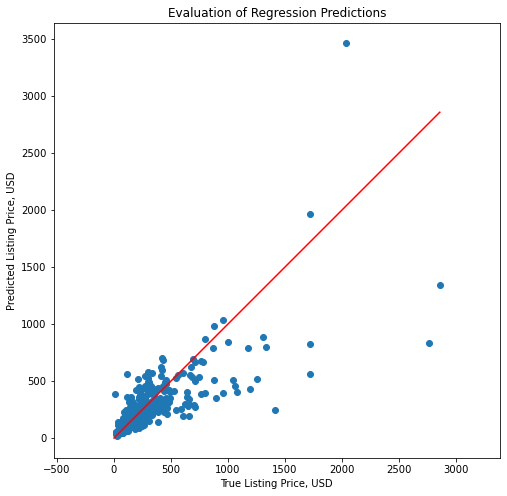

In [112]:
# Real vs. Predicted
# The R2 is only 0.54
# We can see that as the price increases, the prediction error increases
# For large prices (> 500 USD) teh model underpredicts the price.
# That is to be expected, since +85% of the listings used to train are below 500 USD
plt.figure(figsize=(8,8))
x = np.exp(y_test)
y = np.exp(lm_lasso.predict(X_test))
plt.scatter(x, y)
plt.plot(np.array([0,np.max(x)],dtype='object'),np.array([0,np.max(x)],dtype='object'),'r-')
plt.xlabel('True Listing Price, USD')
plt.ylabel('Predicted Listing Price, USD')
plt.title('Evaluation of Regression Predictions')
plt.axis('equal')

#### Error Histogram

The errors are clearly not normally disturbuted. There are large deviations for low and, specially, for large price values.

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

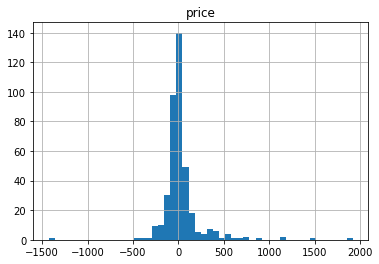

In [113]:
error = x - y
error.hist(bins=50,figsize=(6,4))

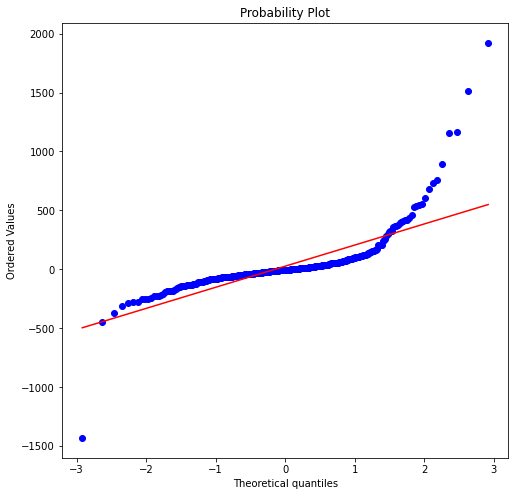

In [114]:
plt.figure(figsize=(8,8))
stats.probplot(error['price'], dist="norm", plot=plt);

### 2.2 Feature Importance

Text(0.5, 1.0, 'Feature Importance')

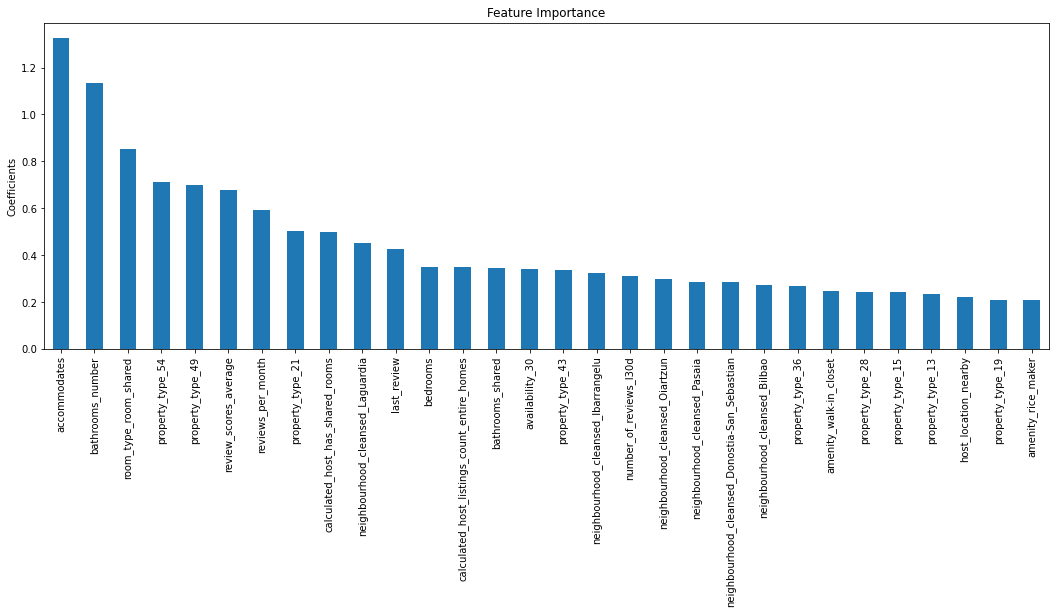

In [118]:
importance = pd.Series(np.abs(lm.coef_.ravel()))
importance.index = selected_features
importance.sort_values(inplace=True, ascending=False)
importance.iloc[:30].plot.bar(figsize=(18,6))
plt.ylabel('Coefficients')
plt.title('Feature Importance')

In [126]:
pd.DataFrame(importance,columns=['importance']).T

,accommodates,bathrooms_number,room_type_room_shared,property_type_54,property_type_49,review_scores_average,reviews_per_month,property_type_21,calculated_host_has_shared_rooms,neighbourhood_cleansed_Laguardia,last_review,bedrooms,calculated_host_listings_count_entire_homes,bathrooms_shared,availability_30,property_type_43,neighbourhood_cleansed_Ibarrangelu,number_of_reviews_l30d,neighbourhood_cleansed_Oiartzun,neighbourhood_cleansed_Pasaia,neighbourhood_cleansed_Donostia-San_Sebastian,neighbourhood_cleansed_Bilbao,property_type_36,amenity_walk-in_closet,property_type_28,property_type_15,property_type_13,host_location_nearby,property_type_19,amenity_rice_maker,property_type_9,calculated_host_listings_count,neighbourhood_cleansed_Getxo,neighbourhood_cleansed_Gorliz,amenity_mosquito_net,maximum_minimum_nights,neighbourhood_cleansed_Irun,amenity_indoor_fireplace,neighbourhood_cleansed_Sopelana,neighbourhood_cleansed_Lekeitio,amenity_paid_street_parking_off_premises,amenity_hot_tub,neighbourhood_group_cleansed_Araba,amenity_drying_rack_for_clothing,property_type_33,host_acceptance_rate,property_type_52,room_type_home,neighbourhood_cleansed_Bermeo,amenity_beachfront,amenity_cooking_basics,amenity_lock_on_bedroom_door,amenity_free_street_parking,amenity_hair_dryer,neighbourhood_group_cleansed_Gipuzkoa,host_response_rate,amenity_bbq_grill,neighbourhood_cleansed_Zarautz,host_response_time_day,amenity_hangers,amenity_conditioner,amenity_air_conditioning,amenity_bidet,amenity_nespresso_machine,amenity_mini_fridge,availability_90,amenity_outdoor_furniture,minimum_minimum_nights,amenity_dishwasher,amenity_sound_system,license_reported,amenity_long_term_stays_allowed,amenity_kitchen,amenity_washer,amenity_backyard,amenity_ethernet_connection,amenity_keypad,amenity_dishes_and_silverware,amenity_babysitter_recommendations,maximum_nights,amenity_wine_glasses,first_review,host_response_time_few_days,amenity_security_cameras_on_property,minimum_nights,amenity_carbon_monoxide_alarm,host_is_superhost,amenity_toaster,amenity_gym,amenity_clothing_storage,amenity_freezer,amenity_paid_parking_off_premises,host_total_listings_count,amenity_microwave,amenity_changing_table,amenity_single_level_home,amenity_beach_essentials,host_response_time_hour,amenity_hdtv,property_type_40,number_of_reviews_ltm,amenity_luggage_dropoff_allowed,amenity_induction_stove,amenity_coffee_maker,amenity_heating,amenity_bathtub,has_beach,amenity_host_greets_you,amenity_first_aid_kit,amenity_patio_or_balcony,amenity_hot_water,amenity_room-darkening_shades,amenity_shampoo,amenity_breakfast,amenity_central_heating,description_language_en,amenity_cleaning_before_checkout,amenity_outdoor_dining_area,amenity_refrigerator,instant_bookable,amenity_bed_linens,amenity_body_soap,amenity_table,amenity_cleaning_products,amenity_hot_water_kettle,amenity_private_entrance,host_identity_verified,calculated_host_listings_count_private_rooms,amenity_extra_pillows_and_blankets,amenity_waterfront,amenity_tv,amenity_paid_parking_on_premises,amenity_pool,amenity_private_patio_or_balcony,host_response_time_few_hours,amenity_free_parking_on_premises
importance,1.326301,1.135279,0.852761,0.711921,0.700703,0.679624,0.590208,0.502276,0.499251,0.452228,0.424219,0.350205,0.34746,0.342448,0.341759,0.33637,0.321145,0.310727,0.296607,0.285389,0.283705,0.273355,0.267504,0.24456,0.241519,0.241242,0.232761,0.21889,0.209143,0.206325,0.205751,0.190923,0.180544,0.176955,0.176511,0.167823,0.163328,0.158449,0.155746,0.149351,0.149081,0.147871,0.144289,0.143995,0.141766,0.132931,0.130598,0.128008,0.125288,0.121489,0.117678,0.117532,0.116646,0.106361,0.105515,0.103092,0.099725,0.099391,0.098279,0.092234,0.089092,0.086367,0.082642,0.081213,0.073801,0.073637,0.073316,0.072341,0.072232,0.070596,0.067652,0.067401,0.067347,0.064423,0.064289,0.064228,0.063428,0.061945,0.06043,0.060027,0.058793,0.056803,0.056054,0.05571,0.051729,0.050823,0.050616,0.050015,0.049066,0.048753,0.048505,0.04778,0.047358,0.047193,0.04669,0.046066,